In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tqdm
from numba import jit

In [2]:
IMAGE_FOLDER = "data/content/"

In [3]:
image_files = os.listdir(IMAGE_FOLDER)
images = [cv.imread(f"{IMAGE_FOLDER}{image}") for image in tqdm.tqdm_notebook(image_files)]

## 1. Extract histogram from 2000 images 

In [4]:
@jit # 40m -> 30s
def calculate_hist(image):
    w, h, d = image.shape
    hist = np.zeros((256, d))
    for i in range(w):
        for j in range(h):
            for channel, value in enumerate(image[i, j, :]):
                hist[value, channel] +=1
    return hist

In [5]:
def calculate_hist_opencv(image):
    b = cv.calcHist([image], [0], None, [256], [0, 256])
    g = cv.calcHist([image], [1], None, [256], [0, 256])
    r = cv.calcHist([image], [2], None, [256], [0, 256])
    return np.hstack([b, g, r])

In [6]:
histograms = [calculate_hist(image) for image in tqdm.tqdm_notebook(images)]

In [7]:
histograms_opencv = [calculate_hist_opencv(image) for image in tqdm.tqdm_notebook(images)]

In [8]:
print("Histogram match: ", (histograms[0] == histograms_opencv[0]).all())

Histogram match:  True


### Results

I have implemented method to calculate histogram and optimized it with JIT compiler because otherwise it takes almost hour to calculate histograms for 2000 images. My implementation is slower than opencv but yields same results

## 2. Write function to measure l2 distance between two images

In [9]:
image_one, image_two = images[:2]

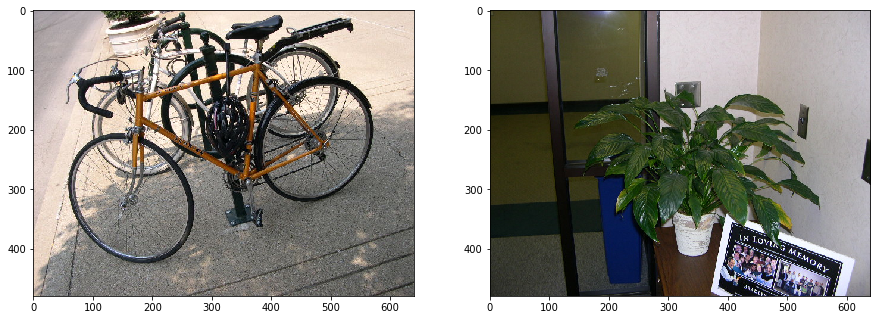

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image_one, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(image_two, cv.COLOR_BGR2RGB))

In [11]:
def l2_distance(hist1, hist2):
    return np.sqrt(np.power(hist1 - hist2, 2).sum())

In [12]:
distance = l2_distance(image_one, image_two)
self_distance = l2_distance(image_one, image_one)

In [13]:
print(f"Distance between image one and image two is {distance}",
      f"\nDistance between image one and image one is {self_distance} (self distance)")

Distance between image one and image two is 9947.44886893117 
Distance between image one and image one is 0.0 (self distance)


## 3. For each query images, find 10 best matches from the 2,000 images based on the color histogram similarity.

In [14]:
query_images = {
    'ukbench00004.jpg': {'ukbench00005.jpg', 'ukbench00006.jpg', 'ukbench00007.jpg'},
    'ukbench00040.jpg': {'ukbench00041.jpg', 'ukbench00042.jpg', 'ukbench00043.jpg'},
    'ukbench00060.jpg': {'ukbench00061.jpg', 'ukbench00062.jpg', 'ukbench00063.jpg'},
    'ukbench00588.jpg': {'ukbench00589.jpg', 'ukbench00590.jpg', 'ukbench00591.jpg'},
    'ukbench01562.jpg': {'ukbench01563.jpg', 'ukbench01560.jpg', 'ukbench01561.jpg'}
}

In [15]:
def find_ordered_matches(query_image, histograms):
    query_histogram = calculate_hist(query_image)
    distances = [l2_distance(query_histogram, im_hist) for im_hist in tqdm.tqdm_notebook(histograms)]
    idxes = np.argsort(np.array(distances))
    return idxes


================================ Query image ================================


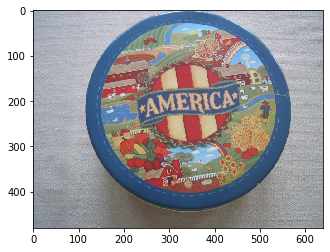

================================ Results image ================================


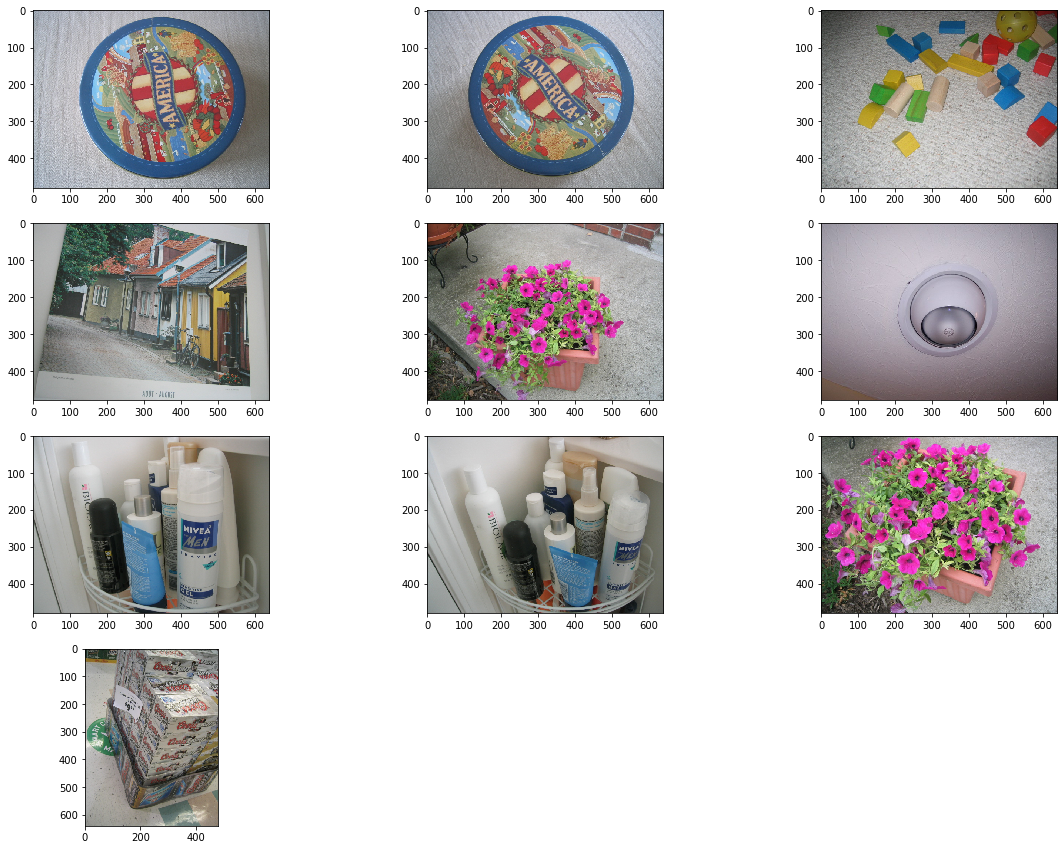


================================ Query image ================================


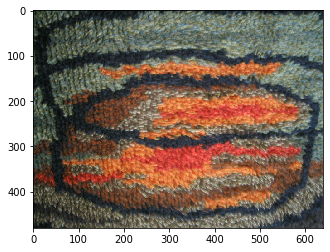

================================ Results image ================================


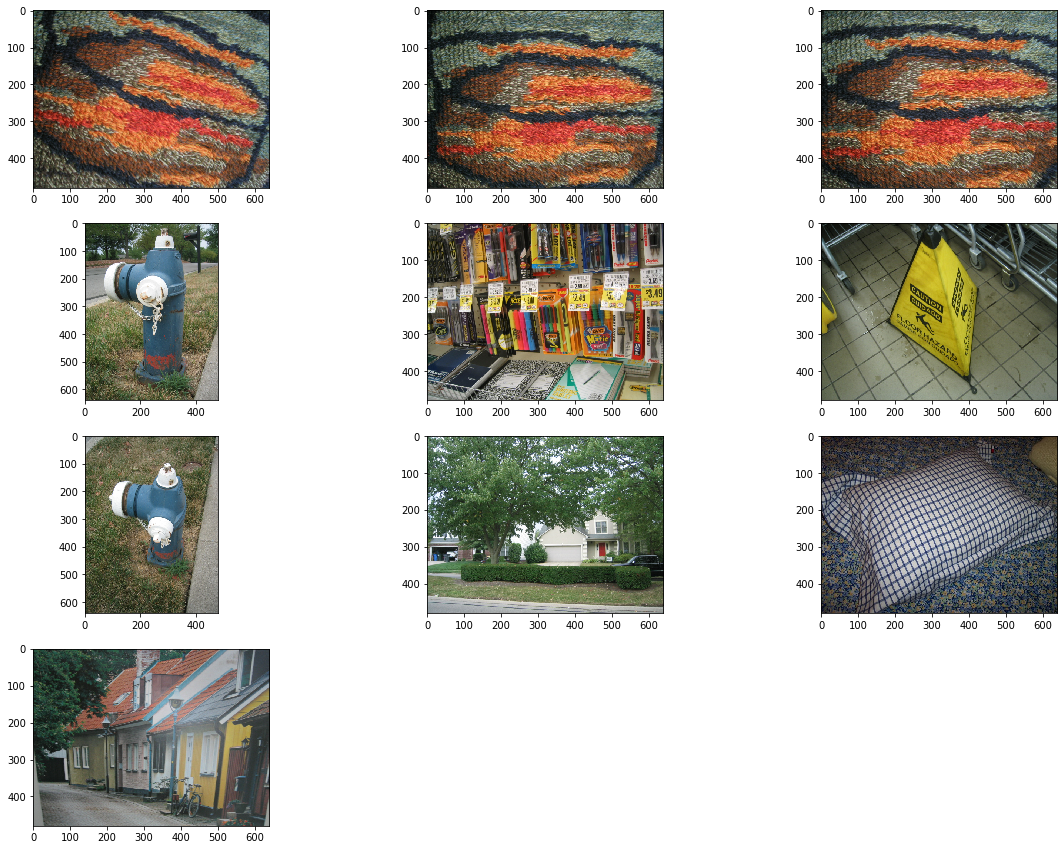


================================ Query image ================================


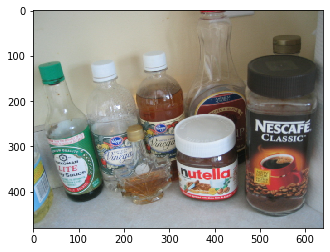

================================ Results image ================================


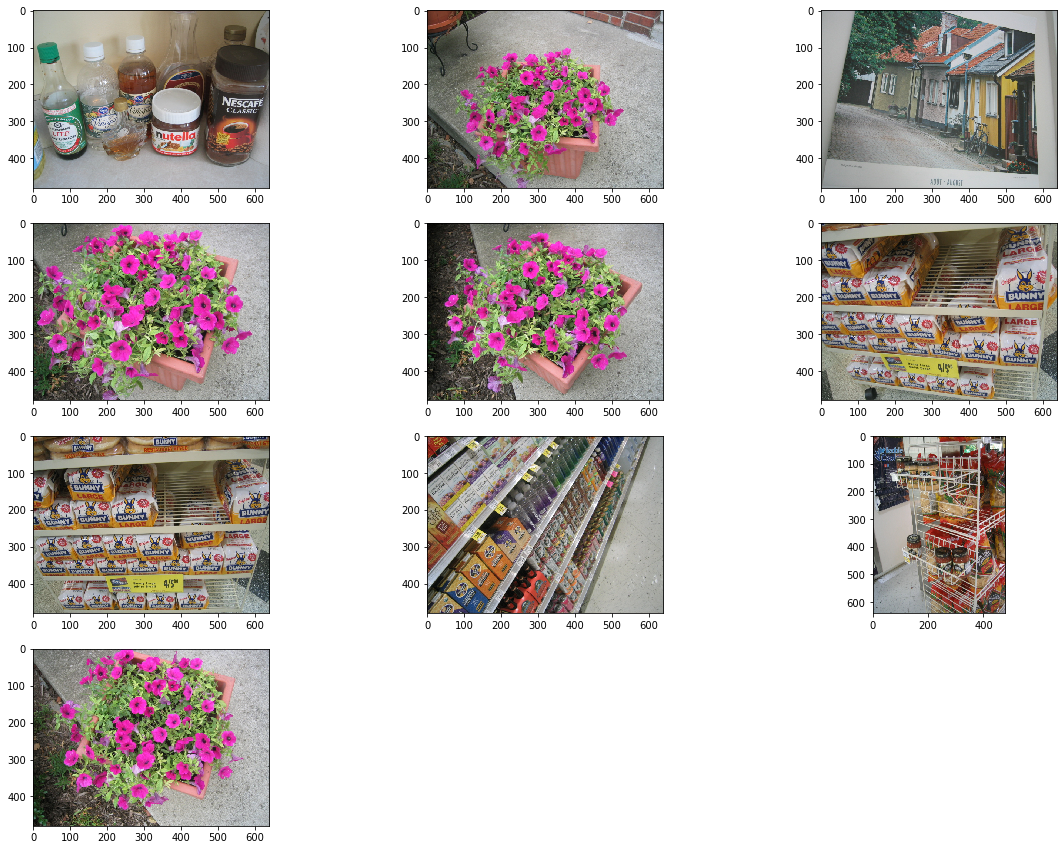


================================ Query image ================================


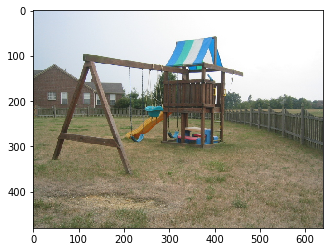

================================ Results image ================================


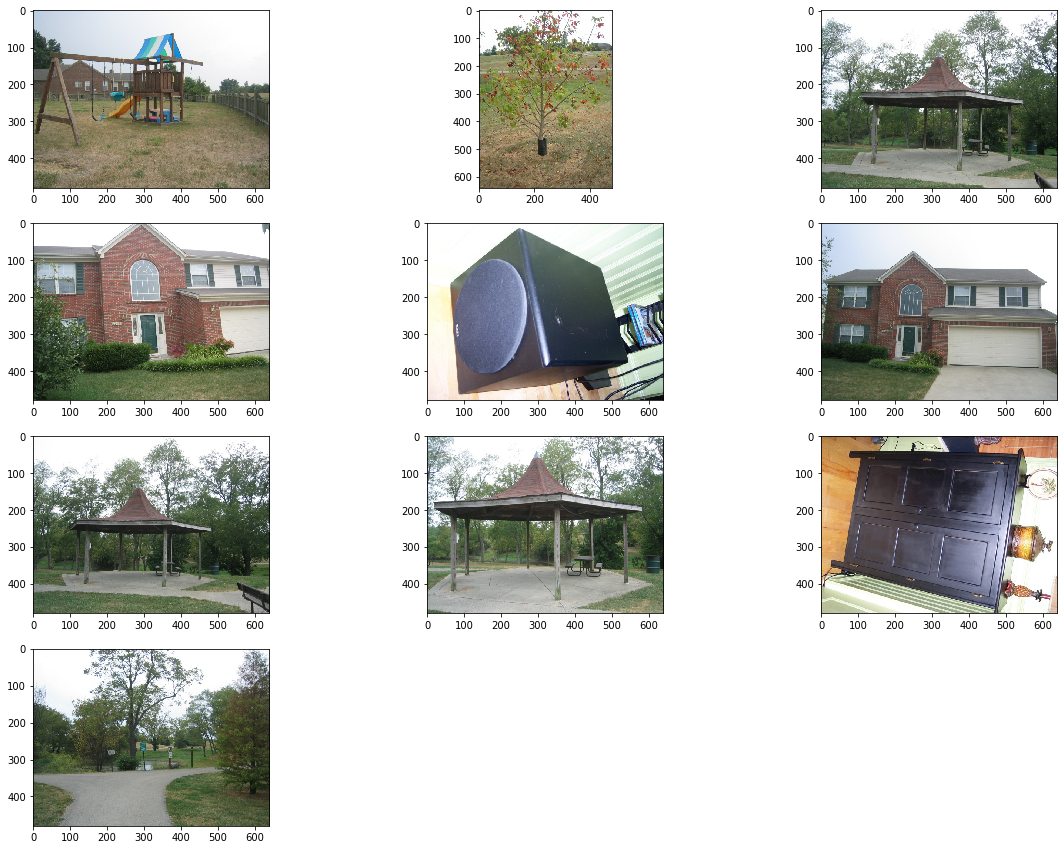


================================ Query image ================================


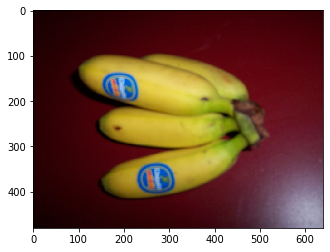

================================ Results image ================================


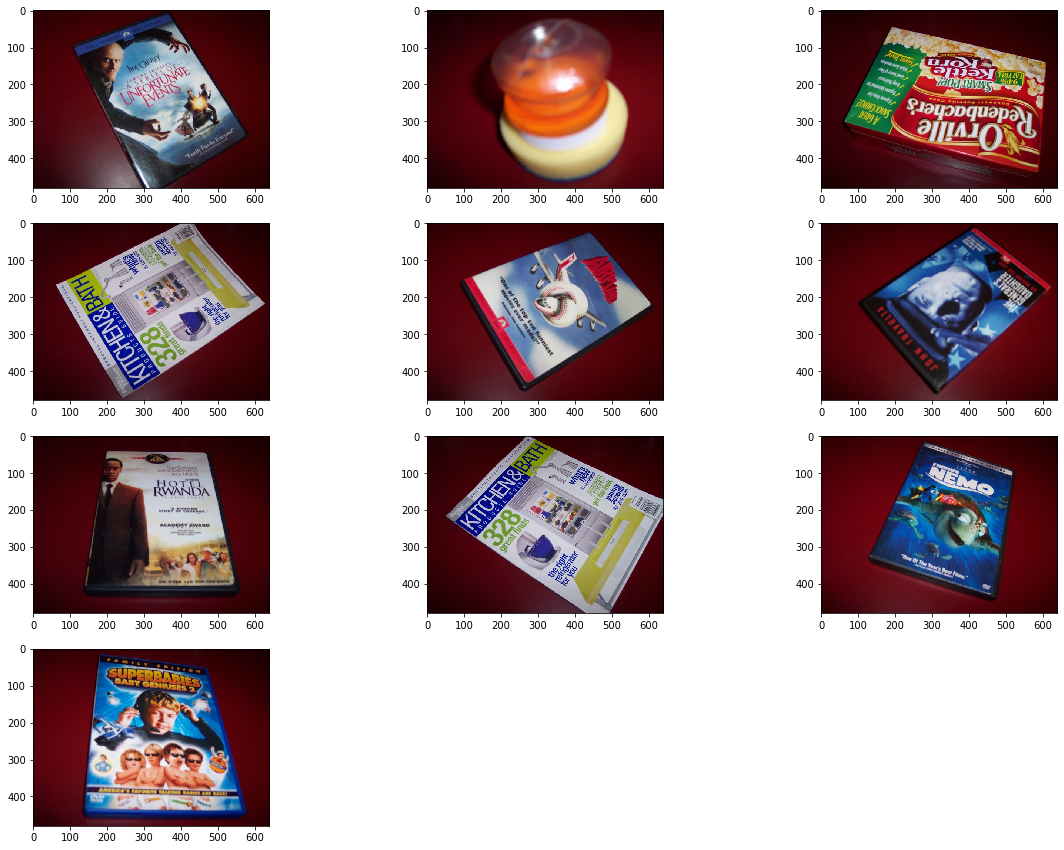

In [16]:
for query_image in query_images.keys():
    query_image_idx = np.where(np.array(image_files) == query_image)[0][0]
    query_image = images[query_image_idx]
    idxes = find_ordered_matches(query_image, histograms)
    results = np.array(images)[idxes[1:11]] # Skip 0 because this will be self distance always
    print("================================ Query image ================================")
    plt.imshow(cv.cvtColor(query_image, cv.COLOR_BGR2RGB))
    plt.show()
    print("================================ Results image ================================")
    plt.figure(figsize=(20, 15))
    for i in range(len(results)):
        plt.subplot(4, 3, i+1)
        plt.imshow(cv.cvtColor(results[i], cv.COLOR_BGR2RGB))
    plt.show()

## 4. Precision / Recall curve

In [17]:
def calculate_precision_recall(gt_images, matched_files):
    tp = len(gt_images.intersection(matched_files))
    fp = len(matched_files.difference(gt_images))
    total = len(gt_images)
    precision = tp / (tp + fp)
    recall = tp / total
    return precision, recall

In [18]:
def plot_pr(prs):
    plt.figure(figsize=(8, 6))
    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,1.05)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.plot(prs[:, 1], prs[:, 0])
    plt.grid(True)
    plt.show()


In [19]:
def precision_recall_curve(image_files, gt_images, idxes, max_items=50):
    prs = []
    for i in range(1, max_items):
        matched_files = set(np.array(image_files)[idxes[1:i+1]]) # Skip 0 because this will be self distance always
        precision, recall = calculate_precision_recall(gt_images, matched_files)
        prs.append((precision, recall))
    prs = np.array(prs)
    return prs


===================== Image ukbench00004.jpg =====================


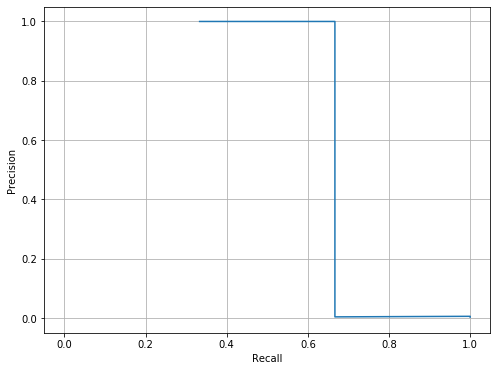


===================== Image ukbench00040.jpg =====================


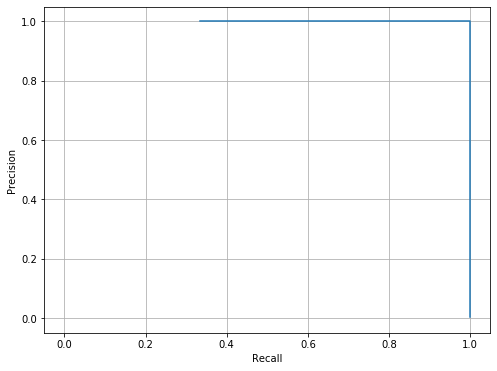


===================== Image ukbench00060.jpg =====================


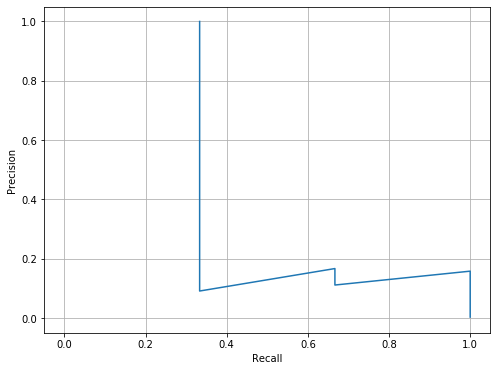


===================== Image ukbench00588.jpg =====================


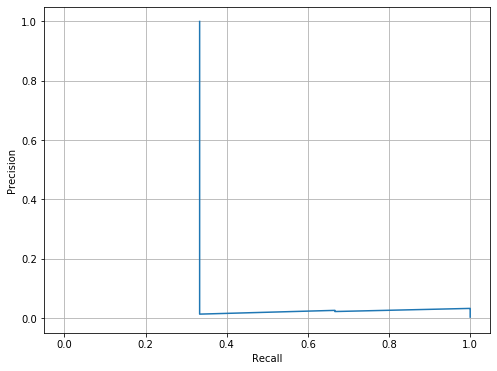


===================== Image ukbench01562.jpg =====================


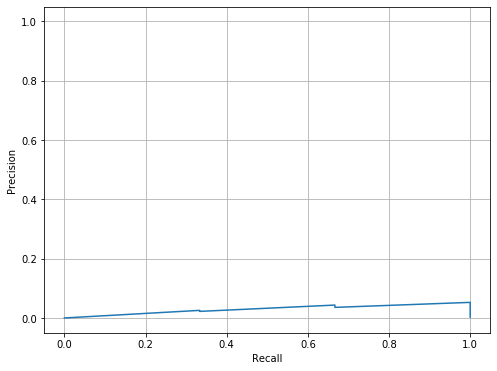

In [20]:
for query_image_name, gt_images in query_images.items():
    query_image_idx = np.where(np.array(image_files) == query_image_name)[0][0]
    query_image = images[query_image_idx]
    idxes = find_ordered_matches(query_image, histograms)
    data = precision_recall_curve(image_files, gt_images, idxes, max_items=1000)
    print(f"===================== Image {query_image_name} =====================")
    plot_pr(data)

## 5. Discuss and explain success and failure cases

We can see that performance of histogram search is not so good. This method is able to find some matches but not all of them. Last query shows that histogram search return not related images but on the same background. Also, because we are using histograms it is very sensitive to color distortion on the images. Also, if object is small most probably the histogram will consist of background mostly.